## Kernel Conditional Discrepancy Test: a replication
Replicates the simulation analysis from Park et al. 2021

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sparse_shift import KCD, KCDCV
import warnings
# warnings.filterwarnings("ignore")

## Simulated data setup

In [55]:
def sample_toy_data(n):
    X = np.random.uniform(0, 1, (n, 1))
    
    X_below = (X < 0.3)[:, 0]
    X_above = (X >= 0.3)[:, 0]
    y0 = 3 + 5*X[:, 0] + X_below * np.random.normal(0, 1, (n)) + X_above * np.random.normal(
        0, np.abs((1 + 7 * (X[:, 0] - 0.3))), (n))
    y1 = 4*X[:, 0] + X_below * np.random.normal(0, 1, (n)) + X_above * np.random.normal(
        0, np.abs((1 + 7 * (X[:, 0] - 0.3))), (n))
    
    return X, np.vstack((y0, y1)).T

## Hypothesis Tests under the null and alternative

In [56]:
n = 100
n_reps = 1000 # 1000
n_power_reps = 100
stats = {'Y0': [], 'Y1': [], 'Y01': []}
pvalues = {'Y0': [], 'Y1': [], 'Y01': []}
fast_pvalue=False

# Pvalues
for i in range(n_power_reps):
    np.random.seed(i)
    X, y_outcomes = sample_toy_data(n)
    z = np.random.choice(2, (n))
    y = np.asarray([outcomes[i] for outcomes, i in zip(y_outcomes, z)])
    # kcd01 = KCD(reg=1.0, n_jobs=10)
    # kcd0 = KCD(reg=1.0, n_jobs=10)
    # kcd1 = KCD(reg=1.0, n_jobs=10)
    kcd01 = KCDCV(n_jobs=-2, regs=[1.0])
    kcd0 = KCDCV(n_jobs=-2, regs=[1.0])
    kcd1 = KCDCV(n_jobs=-2, regs=[1.0])

    stat, pvalue = kcd01.test(X, y, z, reps=n_reps, fast_pvalue=fast_pvalue)
    stats['Y01'].append(stat)
    pvalues['Y01'].append(pvalue)
    
    stat, pvalue = kcd0.test(X, y_outcomes[:, 0], z, reps=n_reps, fast_pvalue=fast_pvalue)
    stats['Y0'].append(stat)
    pvalues['Y0'].append(pvalue)
    
    stat, pvalue = kcd1.test(X, y_outcomes[:, 1], z, reps=n_reps, fast_pvalue=fast_pvalue)
    stats['Y1'].append(stat)
    pvalues['Y1'].append(pvalue)

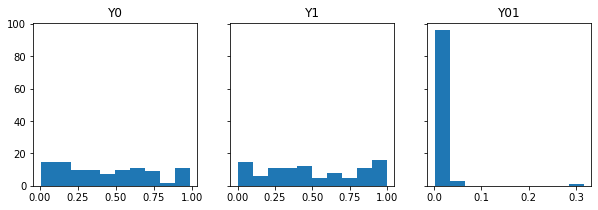

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), sharey=True)
for i, (key, val) in enumerate(pvalues.items()):
    ax = axes[i]
    ax.hist(val)
    ax.set_title(key)
plt.show()

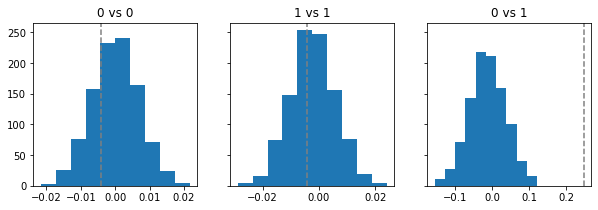

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), sharey=True)
for ax, key, kcd in zip(axes, ['0 vs 0', '1 vs 1', '0 vs 1'], [kcd0, kcd1, kcd01]):
    ax.hist(kcd.null_stats_)
    ax.axvline(kcd.stat_, ls='--', c='grey', label='test statistic')
    ax.set_title(key)
plt.show()

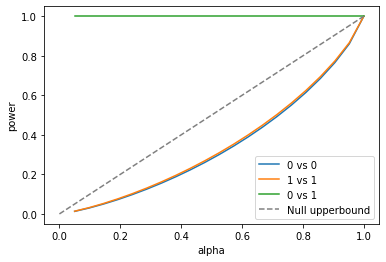

In [59]:
for key, kcd in zip(['0 vs 0', '1 vs 1', '0 vs 1'], [kcd0, kcd1, kcd01]):
    plt.plot(kcd.power_alphas_, kcd.analytic_powers_, label=key)
plt.plot([0, 1], [0, 1], ls='--', c='grey', label='Null upperbound')
plt.xlabel('alpha')
plt.ylabel('power')
plt.legend()
plt.show()

## Application of the witness function

In [106]:
np.random.seed(100)
n = 1000
X, y_outcomes = sample_toy_data(n)
z = np.random.choice(2, (n))
y = np.asarray([outcomes[i] for outcomes, i in zip(y_outcomes, z)])
    
# Witness function
X_lin = np.linspace(0, 1, 1000)
Y_lin = np.linspace(-10, 25, 1000)

kcd = KCD(reg=1.0, n_jobs=10)
witness_mat = kcd.witness(X, y, z, X_lin, Y_lin)

## Results

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Raw data and mean trend lines
ax = axes[0]
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_title('(a) Data')
ax.scatter(X[:, 0], y_outcomes[:, 0], label=r'$Y_0$', c='blue', marker='x', alpha=0.2)
ax.plot(
    np.linspace(0, 1, 10), 3+5*np.linspace(0, 1, 10),
    label=r'$E[Y_0|X]$', c='darkblue', linewidth=2, ls='-')
ax.scatter(X[:, 0], y_outcomes[:, 1], label=r'$Y_1$', c='orange', marker='o', alpha=0.2)
ax.plot(
    np.linspace(0, 1, 10), 4*np.linspace(0, 1, 10),
    label=r'$E[Y_1|X]$', c='orangered', linewidth=2, ls='-')
ax.legend(loc='upper left')

# Hypothesis test results
ax = axes[1]
ax.set_ylabel('Proportion of tests rejected')
ax.set_xlabel('Hypothesis')
ax.set_title('(b) Hypothesis Test')

alpha = 0.05
ax.bar(
    [1, 2, 3],
    [np.mean(np.asarray(pvalues['Y0']) <= alpha),
     np.mean(np.asarray(pvalues['Y1']) <= alpha),
     np.mean(np.asarray(pvalues['Y01']) <= alpha)],
    align='center')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels([
    r'$P_{Y_0|X}$ vs $P_{Y_0|X}$',
    r'$P_{Y_1|X}$ vs $P_{Y_1|X}$',
    r'$P_{Y_0|X}$ vs $P_{Y_1|X}$'])

# Witness function
ax = axes[2]
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_title('(c) Conditional Witness Function')
cm = ax.pcolormesh(X_lin, Y_lin, witness_mat, cmap='magma')
fig.colorbar(cm, ax=ax)

plt.show()